# Setup

**Imports**

In [438]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from loadmydata.load_human_locomotion import (
    load_human_locomotion_dataset,
    get_code_list,
)

**Utility functions**

In [439]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.autoscale(enable=True, axis='x', tight=True)
    return fig, ax

# Spectral feature

## Question 6

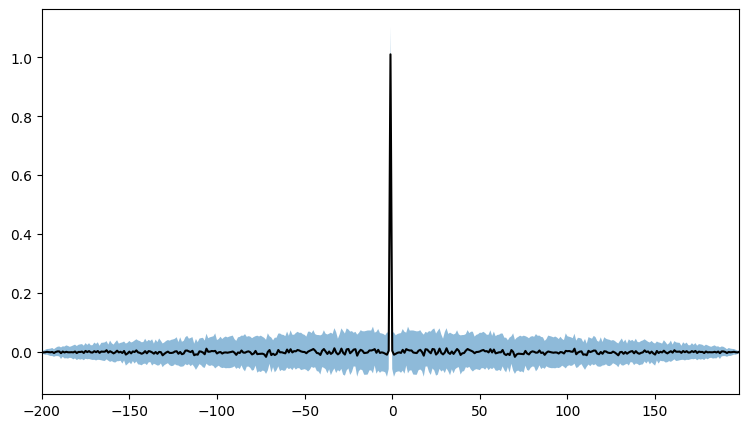

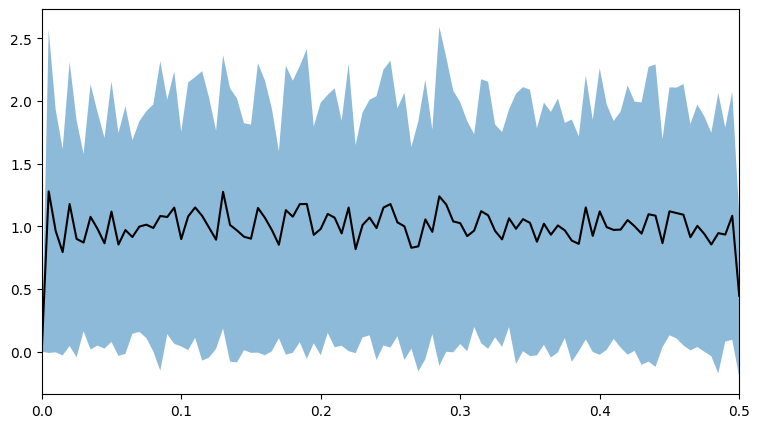

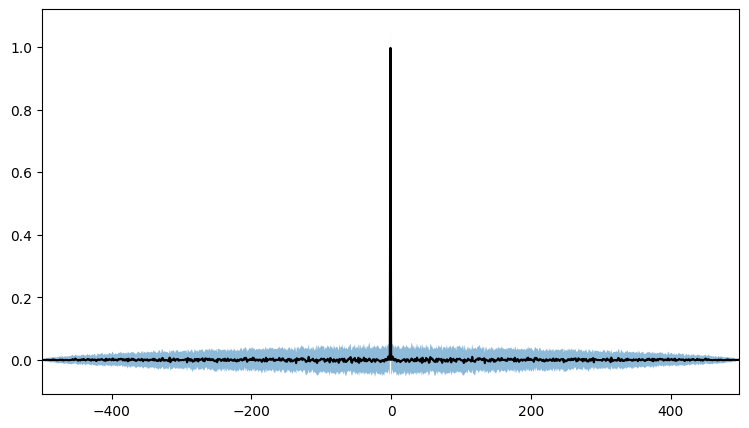

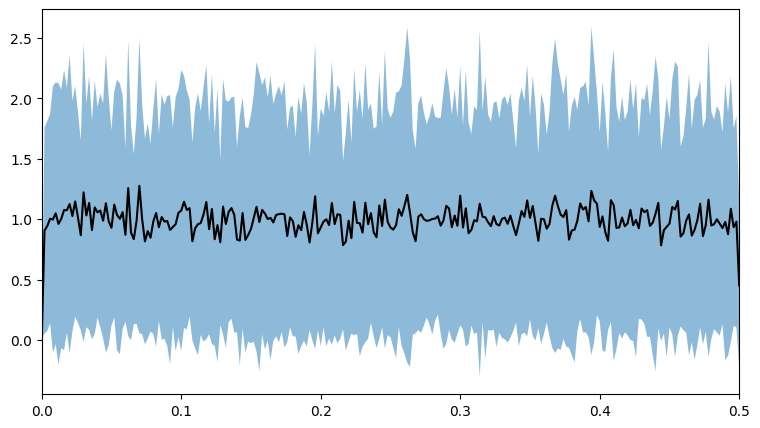

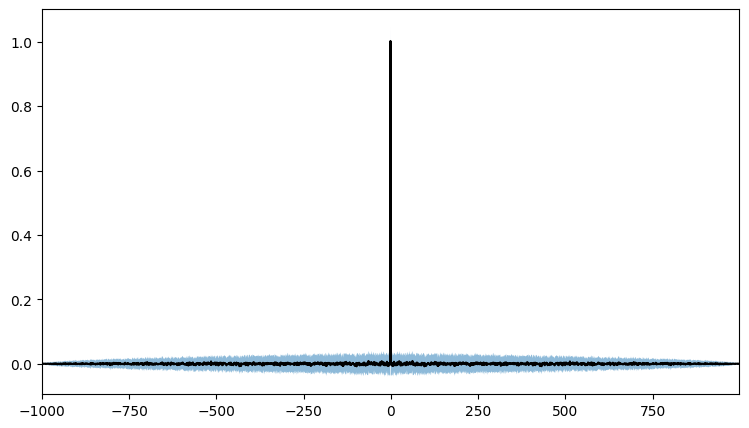

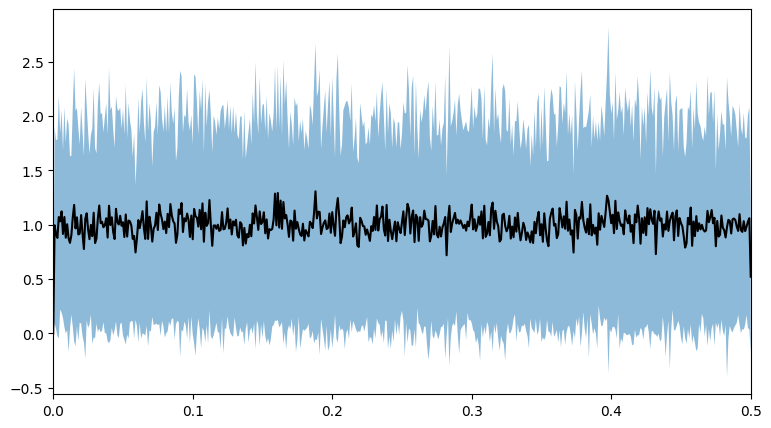

In [468]:
Ns = [200, 500, 1000]
nb_simulations = 100
std = 1
fs = 1

for N in Ns:

    # sample autocovariances
    freqs = np.arange(2*N-1)-N
    samples = np.random.normal(0, std, size=(nb_simulations, N))
    autocovs = np.zeros((nb_simulations, 2*N-1))
    periodograms = np.zeros((nb_simulations, N//2+1))

    for i in range(nb_simulations):
        autocovs[i] = np.correlate(samples[i], samples[i], 'full')/N

        # periodograms
        fks, periodogram = signal.periodogram(samples[i], fs)
        periodograms[i] = periodogram/2

    means_autocov = autocovs.mean(axis=0)
    stds_autocov = autocovs.std(axis=0)

    means_perio = periodograms.mean(axis=0)
    stds_perio = periodograms.std(axis=0)

    fig, ax = fig_ax(figsize=(9, 5))
    ax.plot(freqs, means_autocov, 'k-')
    ax.fill_between(freqs, means_autocov-stds_autocov, means_autocov+stds_autocov, alpha=0.5)
    fig.savefig(f'autocov{N}.png')

    fig, ax = fig_ax(figsize=(9, 5))
    ax.plot(fks, means_perio, 'k-')
    ax.fill_between(fks, means_perio-stds_perio, means_perio+stds_perio, alpha=0.5)
    fig.savefig(f'periodo{N}.png')

## Question 9

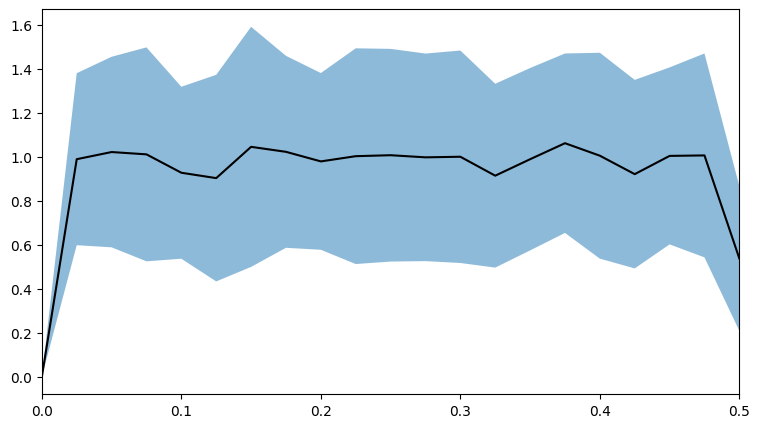

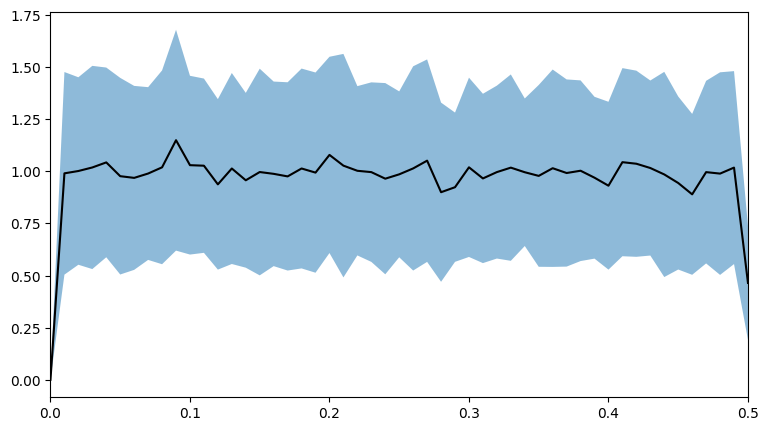

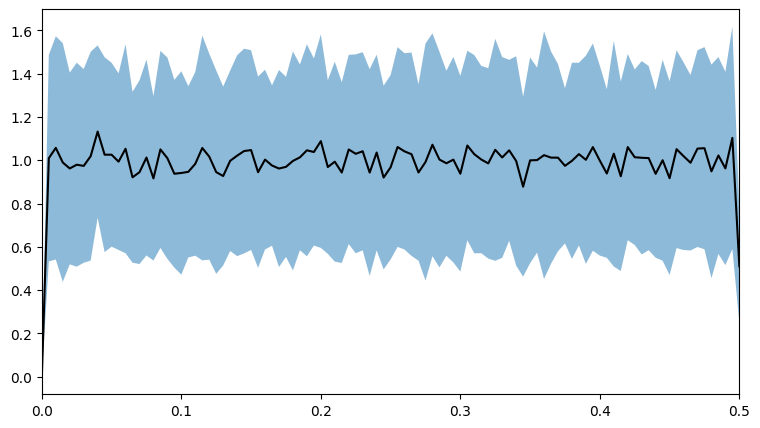

In [469]:
Ns = [200, 500, 1000]
nb_simulations = 100
std = 1
fs = 1
K = 5

for N in Ns:

    samples = np.random.normal(0, std, size=(nb_simulations, N)).reshape((nb_simulations, K, N//K))
    periodograms = np.zeros((nb_simulations, K, N//(2*K)+1))

    for i in range(nb_simulations):

        for k in range(K):

            fks, periodogram = signal.periodogram(samples[i][k])
            periodograms[i][k] = periodogram/2

    periodograms = periodograms.mean(axis=1)

    means_perio = periodograms.mean(axis=0)
    stds_perio = periodograms.std(axis=0)

    fig, ax = fig_ax(figsize=(9, 5))
    ax.plot(fks, means_perio, 'k-')
    ax.fill_between(fks, means_perio-stds_perio, means_perio+stds_perio, alpha=0.5)
    fig.savefig(f'periodoK{N}.png')

# Dynamic time warping (DTW)

## Data

This data set consists of signals collected with inertial measurement units (accelerometer+gyroscope), from 230 subjects undergoing a fixed protocol:
- standing still,
- walking 10 m,
- turning around,
- walking back,
- stopping.

In this assignment, we only consider the vertical acceleration of the left foot and all signals are truncated to 20 seconds (as a result, they all have same length). Signals are sampled at 100 Hz.

The measured population is composed of healthy subjects as well as patients with neurological or orthopedic disorders.

The start and end time stamps of thousands of footsteps are available.

The data are part of a larger data set described in [1].

[1] Truong, C., Barrois-Müller, R., Moreau, T., Provost, C., Vienne-Jumeau, A., Moreau, A., Vidal, P.-P., Vayatis, N., Buffat, S., Yelnik, A., Ricard, D., & Oudre, L. (2019). A data set for the study of human locomotion with inertial measurements units. Image Processing On Line (IPOL), 9.

**The task** is to classify footsteps in healthy/non-healthy.

The following cell defines the training set `(X_train, y_train)` and testing set `(X_test, y_test)`.

In [433]:
subset_indexes_train = [95, 619, 441, 149, 951, 803, 214, 34, 37, 630]
subset_indexes_test = [683, 259, 59, 387, 634]

code_list = get_code_list()

X_train = list()  # list of footstep signals
y_train = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_train):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_train.append(signal[start:end])
        y_train.append(label)

        
X_test = list()  # list of footstep signals
y_test = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_test):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_test.append(signal[start:end])
        y_test.append(label)

## Question 10

In [434]:
from tslearn.utils import to_time_series_dataset
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, f1_score

In [435]:
X = X_train + X_test
y = y_train + y_test

X_ts = to_time_series_dataset(X)
X_train_ts = to_time_series_dataset(X_train)
X_test_ts = to_time_series_dataset(X_test)

In [436]:
knn_model = KNeighborsTimeSeriesClassifier(metric='dtw')

k_values = np.arange(1, 10)
f1s = np.zeros(9)
for k in k_values:

    knn_model.n_neighbors = k
    scores = cross_val_score(knn_model, X_ts, y, cv=5, scoring='f1')
    mean_accuracy = scores.mean()
    f1s[k-1] = mean_accuracy
    print(f'F1-score for n_neighbors={k}: {mean_accuracy:.3f}')

F1-score for n_neighbors=1: 0.767
F1-score for n_neighbors=2: 0.731
F1-score for n_neighbors=3: 0.786
F1-score for n_neighbors=4: 0.739
F1-score for n_neighbors=5: 0.765
F1-score for n_neighbors=6: 0.736
F1-score for n_neighbors=7: 0.767
F1-score for n_neighbors=8: 0.746
F1-score for n_neighbors=9: 0.748


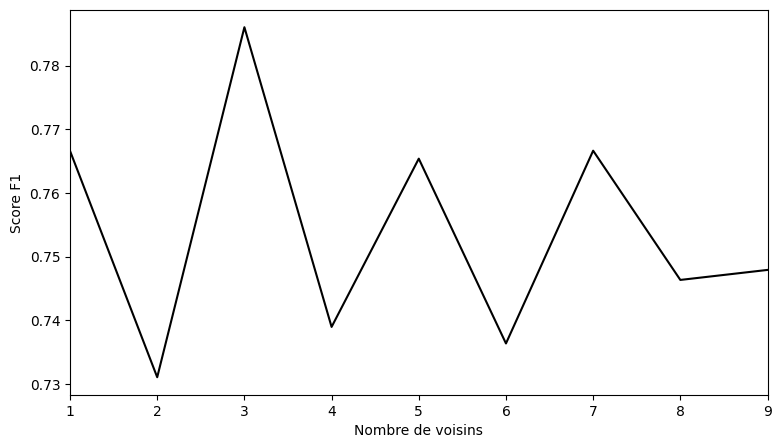

In [470]:
fig, ax = fig_ax(figsize=(9, 5))
ax.plot(k_values, f1s, 'k-')
ax.set_xlabel('Nombre de voisins')
ax.set_ylabel('Score F1');
fig.savefig(f'kselection.png')

In [454]:
from sklearn.model_selection import train_test_split

X_train_ts, X_test_ts, y_train, y_test = train_test_split(X_ts, y, test_size=0.33)

knn_model = KNeighborsTimeSeriesClassifier(n_neighbors= 3, metric="dtw")
knn_model.fit(X_train_ts, y_train)

KNeighborsTimeSeriesClassifier(n_neighbors=3)

In [455]:
y_pred = knn_model.predict(X_test_ts)

In [456]:
print(confusion_matrix(y_pred, y_test))
print(f'F1-score : {f1_score(y_pred, y_test):.3f}')

[[29  6]
 [ 4 46]]
F1-score : 0.902


## Question 11

In [462]:
fp_indices = [i for i in range(len(y_test)) if y_test[i] == 0 and y_pred[i] == 1]
fn_indices = [i for i in range(len(y_test)) if y_test[i] == 1 and y_pred[i] == 0]
fp_indices

[9, 48, 50, 73]

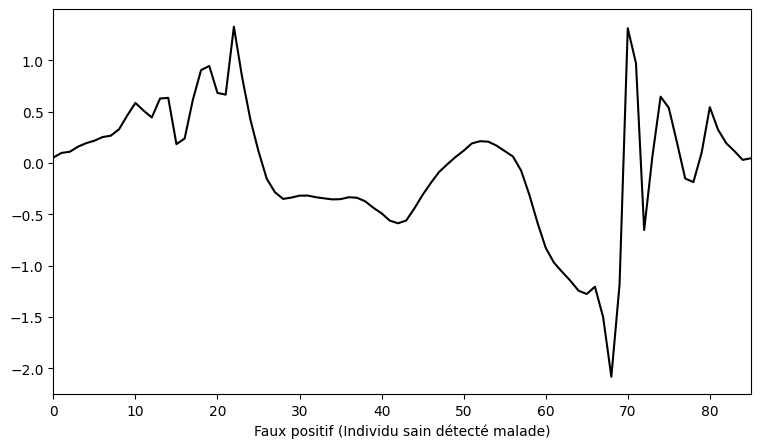

In [471]:
fig, ax = fig_ax(figsize=(9, 5))
ax.plot(X_test_ts[fp_indices[0]], 'k-')
ax.set_xlabel('Faux positif (Individu sain détecté malade)');
fig.savefig(f'FP.png')

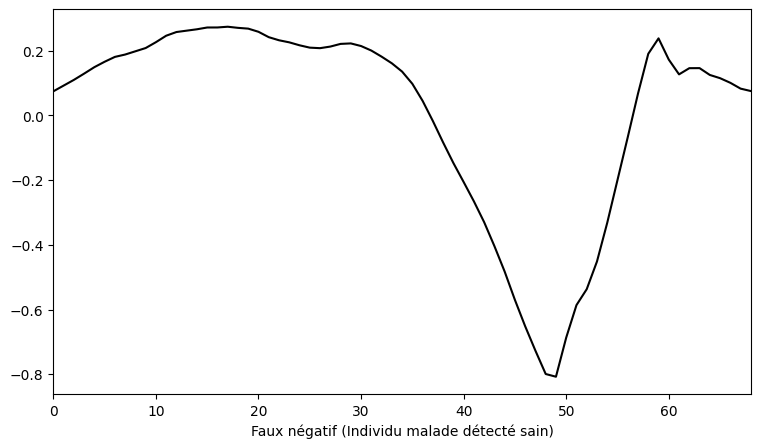

In [472]:
fig, ax = fig_ax(figsize=(9, 5))
ax.plot(X_test_ts[fn_indices[0]], 'k-')
ax.set_xlabel('Faux négatif (Individu malade détecté sain)');
fig.savefig(f'FN.png')